### This file makes a shapefile from the stations from stationAttr72.csv.  It also maps those points according to their trend and buffers them to download SRTM DEMs

In [1]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from shapely.geometry import Point
from pathlib import Path
from scipy import stats
import contextily as ctx
import mplleaflet
import fiona
import elevation
import rasterio
from rasterio.transform import from_bounds, from_origin
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show
import earthpy as et
import seaborn as sns
# Prettier plotting with seaborn
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [2]:
#change directory to the data_light directory
os.chdir(os.path.join(str(Path.home()),
                      "Documents/research/wind/globalWindTrends/data_light"))

In [3]:
df=pd.read_csv('stationAttr72.csv')
df.head(),df.shape

(  stationNumber     slope  lowBound  hightBound  slopeInt  pw1972  pw2017
 0  483570-99999 -0.134197 -0.185880   -0.082513        -1   135.0    74.0
 1  722310-12916 -0.083380 -0.148009   -0.018750        -1    78.0   121.0
 2  702710-26425 -0.092815 -0.161811   -0.023820        -1   190.0   157.0
 3  948420-99999 -0.286895 -0.391642   -0.182148        -1   287.0   292.0
 4  943320-99999  0.347579  0.278563    0.416596         1   119.0   131.0,
 (88, 7))

In [4]:
#let's check if there are any NAN's in any of the rows
df.isnull().values.any()

True

In [5]:
#check to see where the null values are
df.isnull().sum()

stationNumber    0
slope            1
lowBound         1
hightBound       1
slopeInt         0
pw1972           0
pw2017           0
dtype: int64

In [6]:
#since there are some null values, we will drop the row(s) with null values
df = df.dropna()
#pandas does not reset index where drop takes place
df.reset_index(drop=True, inplace=True)

df.shape

(87, 7)

In [7]:
#Need to add some attributes from ID_Info.csv
df_id = pd.read_csv("ID_Info.csv")
df_id.head()

,ID,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,Timespan
0,008268-99999,8268,99999,WXPOD8278,AF,NaN,NaN,32.950,65.567,1156.7,2010-05-19,2012-03-23,674
1,010010-99999,10010,99999,JAN MAYEN(NOR-NAVY),NO,NaN,ENJA,70.933,-8.667,9.0,1931-01-01,2017-05-22,31553
2,010014-99999,10014,99999,SORSTOKKEN,NO,NaN,ENSO,59.792,5.341,48.8,1986-11-20,2017-05-22,11141
3,010015-99999,10015,99999,BRINGELAND,NO,NaN,NaN,61.383,5.867,327.0,1987-01-17,2011-10-20,9042
4,010016-99999,10016,99999,RORVIK/RYUM,NO,NaN,NaN,64.850,11.233,14.0,1987-01-16,1991-08-06,1663


In [8]:
#add the columns that we will get from ID_Info.csv to df
df["elev"] = np.nan
df["lat"] = np.nan
df["lon"] = np.nan
df.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon
0,483570-99999,-0.134197,-0.185880,-0.082513,-1,135.0,74.0,NaN,NaN,NaN
1,722310-12916,-0.083380,-0.148009,-0.018750,-1,78.0,121.0,NaN,NaN,NaN
2,702710-26425,-0.092815,-0.161811,-0.023820,-1,190.0,157.0,NaN,NaN,NaN
3,948420-99999,-0.286895,-0.391642,-0.182148,-1,287.0,292.0,NaN,NaN,NaN
4,943320-99999,0.347579,0.278563,0.416596,1,119.0,131.0,NaN,NaN,NaN


In [9]:
#fill in the new columns with info from ID_Info.csv
nr = df.shape[0]
for i in range(nr):
    sn = df["stationNumber"][i]
    
    #get the index in df_id associated with that staion number
    idx = df_id.index[df_id['ID']==sn][0]
    
    df.loc[[i],['elev']] = df_id["ELEV(M)"][idx]
    df.loc[[i],['lat']] = df_id["LAT"][idx]
    df.loc[[i],['lon']] = df_id["LON"][idx]
df.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon
0,483570-99999,-0.134197,-0.185880,-0.082513,-1,135.0,74.0,148.0,17.417,104.783
1,722310-12916,-0.083380,-0.148009,-0.018750,-1,78.0,121.0,1.2,29.998,-90.278
2,702710-26425,-0.092815,-0.161811,-0.023820,-1,190.0,157.0,476.1,62.159,-145.459
3,948420-99999,-0.286895,-0.391642,-0.182148,-1,287.0,292.0,83.0,-38.850,143.517
4,943320-99999,0.347579,0.278563,0.416596,1,119.0,131.0,341.7,-20.664,139.489


## Look at the distribution of mean wind speed trends

In [10]:
dfNeg = df[df['slopeInt']== -1]
dfZero = df[df['slopeInt']== 0]
dfPos = df[df['slopeInt']== 1]

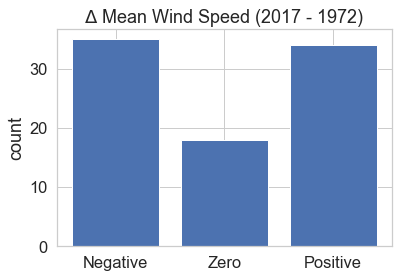

In [11]:
#plot the number of neg,zero,pos trends
x = np.arange(3)
plt.bar(x,[len(dfNeg), len(dfZero), len(dfPos)])
plt.xticks(x,("Negative","Zero", "Positive"));
plt.title("$\Delta$ Mean Wind Speed (2017 - 1972)")
plt.ylabel("count");

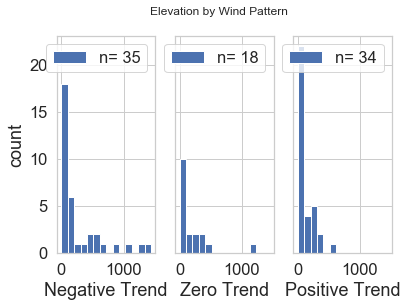

In [12]:
#Look at the elevation by change in wind speed pattern
b = np.linspace(0,max(df.elev),15)
#fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex = True);
fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey = True);
ax1.hist(dfNeg["elev"],bins=b,label = "n= "+str(len(dfNeg["elev"])));
ax1.set_ylabel("count")
ax1.set_xlabel("Negative Trend")
ax1.legend()

ax2.hist(dfZero["elev"],bins=b,label = "n= "+str(len(dfZero["elev"])));
ax2.set_xlabel("Zero Trend")
ax2.legend()

ax3.hist(dfPos["elev"],bins = b,label = "n= "+str(len(dfPos["elev"])));
ax3.set_xlabel("Positive Trend")
ax3.legend()

fig.suptitle("Elevation by Wind Pattern");

In [13]:
# are these distributions different? (they don't look it...)
# we use a Kolmogorov-Smirnov test
e1 = dfNeg["elev"]
e2 = dfZero['elev']
e3 = dfPos['elev']
for dist in [e1,e2,e3]:
    for dist2 in [e1,e2,e3]:
        print(stats.ks_2samp(dist,dist2))

Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.20158730158730154, pvalue=0.6682378959329579)
Ks_2sampResult(statistic=0.27058823529411763, pvalue=0.13346046176425486)
Ks_2sampResult(statistic=0.20158730158730154, pvalue=0.6682378959329579)
Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.2777777777777778, pvalue=0.27518807616285823)
Ks_2sampResult(statistic=0.27058823529411763, pvalue=0.13346046176425486)
Ks_2sampResult(statistic=0.2777777777777778, pvalue=0.27518807616285823)
Ks_2sampResult(statistic=0.0, pvalue=1.0)


## Plotting the points

In [14]:
# A GeoDataFrame needs a shapely object, so we create a new 
#column 'coordinates' as a tuple of 'lat' and 'lon'
df['coordinates'] = list(zip(df.lon, df.lat)) #(x,y ==> lon,lat)

#transform tuples to Point
df['coordinates'] = df['coordinates'].apply(Point)

#now we can create the GeoDataFrame by setting geometry with 
#previosly created coordinates
gdf = gpd.GeoDataFrame(df,geometry= 'coordinates')

In [15]:
#Need to set the coordinate system (epsg:4269 = NAD83 datum) 
#3857 = pseudo-mercator
gdf.crs = {'init' :'epsg:4269'}
gdf = gdf.to_crs({'init' :'epsg:3857'}) #switch to pseudo-mercator 

In [16]:
#we need to add a string column that represents slopeInt for better
#plotting
def createString(gdf):
    if gdf["slopeInt"] == -1:
        return "Negative"
    elif gdf["slopeInt"] ==0:
        return "Zero"
    elif gdf["slopeInt"]==1:
        return "Positive"
    else:
        return "Big trouble in little china!"
gdf['trend'] = gdf.apply(createString, axis = 1)
gdf.head(2)

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon,coordinates,trend
0,483570-99999,-0.134197,-0.185880,-0.082513,-1,135.0,74.0,148.0,17.417,104.783,POINT (11664390.20379158 1969420.804624172),Negative
1,722310-12916,-0.083380,-0.148009,-0.018750,-1,78.0,121.0,1.2,29.998,-90.278,POINT (-10049700.98983515 3503292.764637826),Negative


In [17]:
# Create a dictionary where you assign each attribute value to a particular color
trendPalette = {"Negative": 'b',
               "Positive": 'r',
               "Zero": 'grey'}

In [18]:
#Read in the world shapefile and set to gdf.crs
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name != "Antarctica")]
world = world.to_crs(gdf.crs)
world.crs, gdf.crs

({'init': 'epsg:3857'}, {'init': 'epsg:3857'})

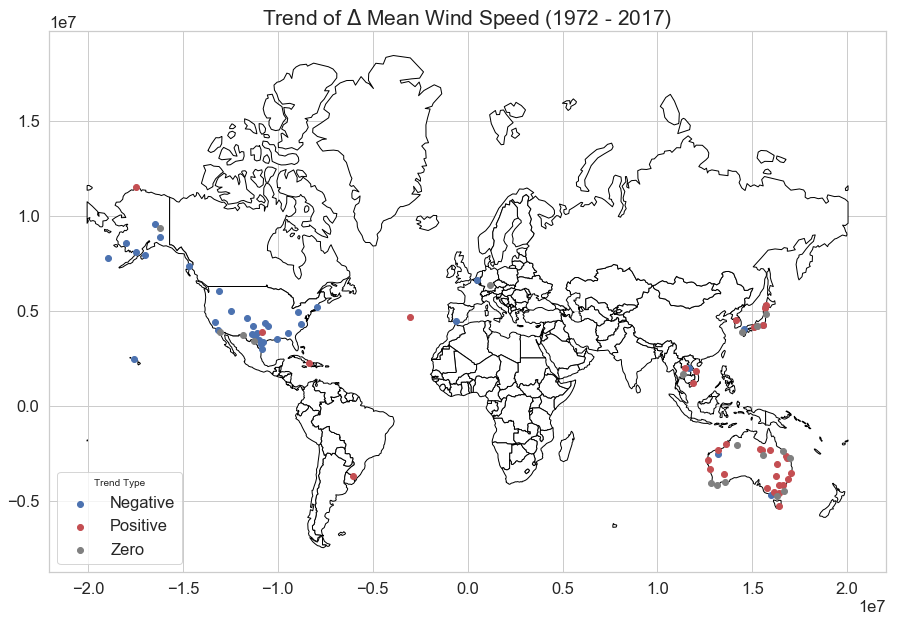

In [19]:
#plot the data
fig,ax = plt.subplots(figsize=(15,15))
world.plot(color = 'white',
           edgecolor = 'black',
           ax = ax)
# show(dem_raster, ax=ax)

#loop through each attribute type and plot it using the colors assigned to the dictionary
for ctype, data in gdf.groupby("trend"):
    color = trendPalette[ctype]
    data.plot(color = color,
              ax = ax,
              label = ctype)
ax.legend(title = "Trend Type",
          loc = "lower left");
ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);


## Plot an interactive version using mplleaflet

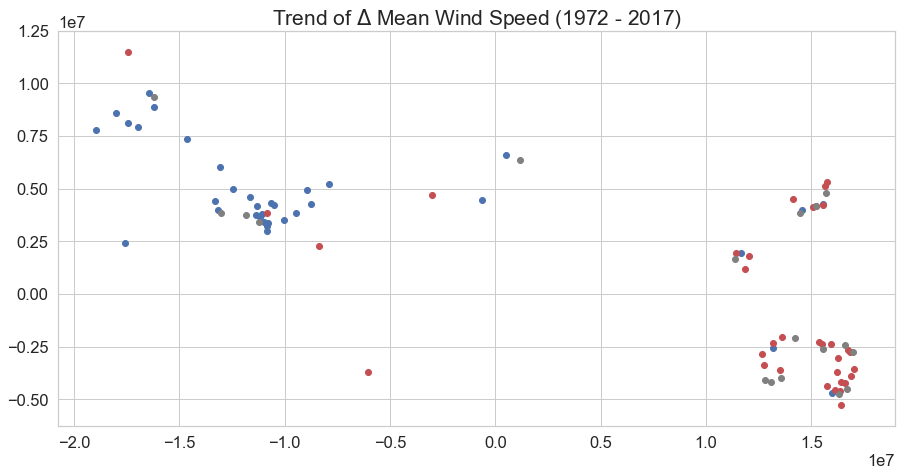

In [20]:
#plot the data
fig,ax = plt.subplots(figsize=(15,15))
#loop through each attribute type and plot it using the colors assigned to the dictionary
for ctype, data in gdf.groupby("trend"):
    color = trendPalette[ctype]
    data.plot(color = color,
              ax = ax,
              label = ctype);
ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);

In [21]:
mplleaflet.display(fig=ax.figure, crs=world.crs)

/anaconda3/envs/GIS/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [22]:
#create a buffer around the weather stations(numbers are meters)
buffer = gdf.coordinates.buffer(1000)
#create a bounding box arund the buffer
boundBox = buffer.envelope
# gdf.head()

In [24]:
#plot the data with the buffer
fig,ax = plt.subplots(figsize=(15,15))
for ctype, data in gdf.groupby("trend"):
    color = trendPalette[ctype]
    data.plot(color = color,
              ax = ax,
              label = ctype);
buffer.plot(ax=ax)
boundBox.plot(ax=ax)

mplleaflet.display(fig=ax.figure, crs=world.crs)
#mplleaflet.display(fig=ax.figure, crs=world.crs,tiles='esri_aerial')

/anaconda3/envs/GIS/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [25]:
type(buffer)

geopandas.geoseries.GeoSeries

In [26]:
#create geodataframe with buffer
demGDF = gpd.GeoDataFrame(buffer,
                          columns = ['geometry'],
                          crs = gdf.crs)

In [27]:
demGDF["stationNumber"] = gdf["stationNumber"]

In [28]:
demGDF.head()

,geometry,stationNumber
0,"POLYGON ((11665390.20379158 1969420.804624172,...",483570-99999
1,POLYGON ((-10048700.98983515 3503292.764637826...,722310-12916
2,POLYGON ((-16191421.81129878 8896943.113846019...,702710-26425
3,POLYGON ((15977239.36017824 -4700208.078372751...,948420-99999
4,POLYGON ((15528844.45126294 -2351858.975811172...,943320-99999


In [29]:
#convert dataframe to WGS84 to use the elevation package for automated
#SRTM DEM extraction
demGDF_WGS84 = demGDF.to_crs({'init' :'epsg:4326'})
demGDF_WGS84.crs, demGDF.crs

({'init': 'epsg:4326'}, {'init': 'epsg:3857'})

In [113]:
os.getcwd()

'/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light'

In [37]:
#code to write geodatabases to shape files
outPathPoints = os.getcwd()+"/outputShapefiles/stationPoints72.shp"
outPathBuffer = os.getcwd()+"/outputShapefiles/stationBuffer72_1k.shp"

gdf.to_file(outPathPoints)
demGDF.to_file(outPathBu)

TypeError: expected str, bytes or os.PathLike object, not GeoDataFrame

In [36]:
outPathPoints

'/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/outputShapefiles/stationPoints72.shp'

## Code block below if for bulk download of SRTM DEM
## Uncomment for usage

In [30]:
# #Download all of the .tif files from the SRTM DEM
# nr = demGDF_WGS84.shape[0]
# for i in range(nr):
#     #get the bounds of the buffer
#     bounds = tuple(demGDF_WGS84.loc[[i],["geometry"]].bounds.values[0])
#     stNum = demGDF_WGS84.loc[[i],["stationNumber"]].values[0][0]
#     outputPath = os.getcwd()+"/1kTiff/"+stNum+"_1k.tif"
#     #call to the elevation package
#     #SRTM1 is the 30m resolution set
#     elevation.clip(bounds = bounds, output = outputPath, product = 'SRTM1')

# Code below will likely be replicated by ArcGIS and is therefore not organized

In [27]:
#convert the buffer to decimal so that we can call the 
#elevation package to get SRTM DEMs
#the elevation package uses WGS84 epsg:4326
bufferDecimal = buffer.to_crs({'init' :'epsg:4326'})

In [174]:
west, south, east, north = bounds =  bufferDecimal.bounds.loc[0]
east - west #just a test to see if we are in decimals

0.017966305682378447

In [31]:
#output path for the DEM 
outputPath = os.getcwd()+"/SRTM_DEMs/test.tif"

In [33]:
#call to the elevation package
#SRTM1 is the 30m resolution set
elevation.clip(bounds = bounds, output = outputPath, product = 'SRTM1')

In [189]:
with rasterio.open(outputPath) as dem_raster:
    print(dem_raster.meta)
    

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 65, 'height': 62, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.0002777777777777778, 0.0, 104.77375,
       0.0, -0.0002777777777777778, 17.425694444444442)}


In [190]:
#this is a raster reproject function
def reproject_et(inpath, outpath, new_crs):
    dst_crs = new_crs # CRS for web meractor 

    with rasterio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [191]:
inpath = outputPath
outpath = '/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/SRTM_DEMs/test3857.tif'

In [192]:
reproject_et(inpath = inpath,
            outpath = outpath,
            new_crs ='EPSG:3857')

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 64, 'height': 64, 'count': 1, 'crs': CRS.from_dict(init='epsg:3857'), 'transform': Affine(31.63863967544067, 0.0, 11663360.49850175,
       0.0, -31.63863967544067, 1970435.1971704613)}

BoundingBox(left=11663360.49850175, bottom=1968410.324231233, right=11665385.371440979, top=1970435.1971704613)


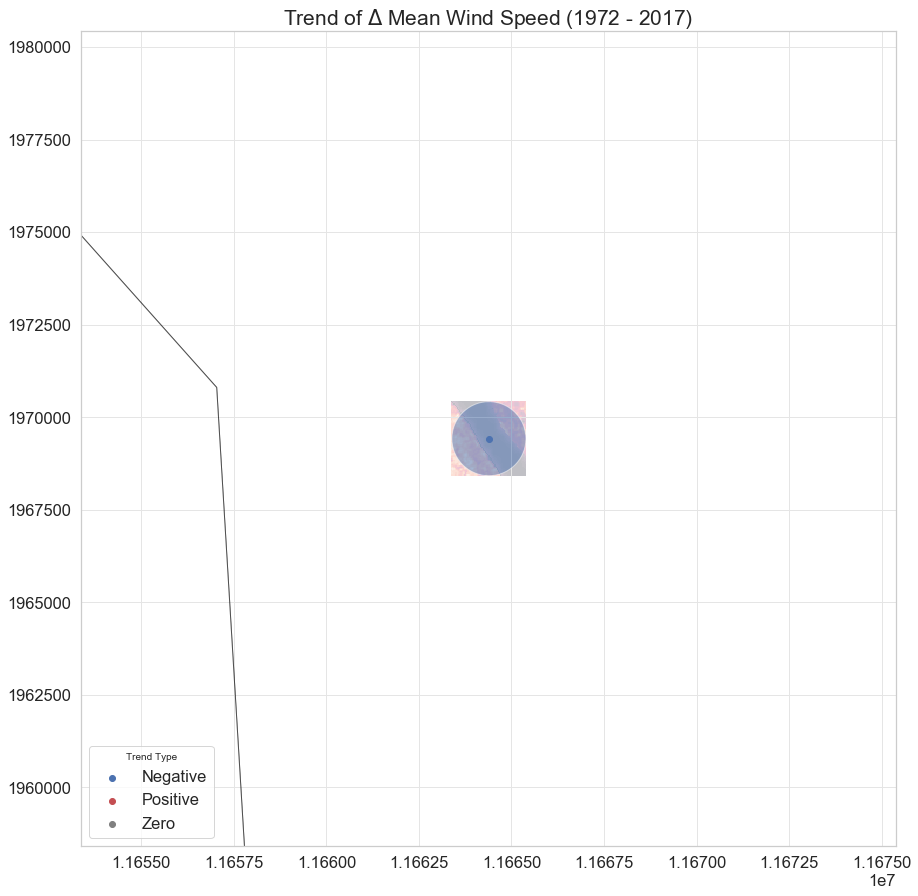

In [193]:
with rasterio.open(outpath) as dem_raster:
    print(dem_raster.meta)
    dem_img = dem_raster.read(1)
    #plot the data
    fig,ax = plt.subplots(figsize=(15,15))
    world.plot(color = 'white',
               edgecolor = 'black',
               ax = ax,
               alpha = 0.5)
    buffer.plot(ax = ax,
               alpha = 0.5)
    show(dem_raster,
         ax=ax,
         alpha = 0.5)

    #loop through each attribute type and plot it using the colors assigned to the dictionary
    for ctype, data in gdf.groupby("trend"):
        color = trendPalette[ctype]
        data.plot(color = color,
                  ax = ax,
                  label = ctype)

    ax.legend(title = "Trend Type",
              loc = "lower left");
    ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);
    print()
    boundsMargin = 10000
    bounds = (dem_raster.bounds[0]-boundsMargin,
              dem_raster.bounds[1]-boundsMargin,
              dem_raster.bounds[2]+boundsMargin,
              dem_raster.bounds[3]+boundsMargin)
    print(dem_raster.bounds)
    ax.set_ylim((dem_raster.bounds[1]-10000,dem_raster.bounds[3]+10000))
    ax.set_xlim((dem_raster.bounds[0]-10000,dem_raster.bounds[2]+10000))

In [74]:
def hillshade(array, azimuth, angle_altitude):

    # Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.


    shaded = np.sin(altituderad) * np.sin(slope) \
     + np.cos(altituderad) * np.cos(slope) \
     * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2

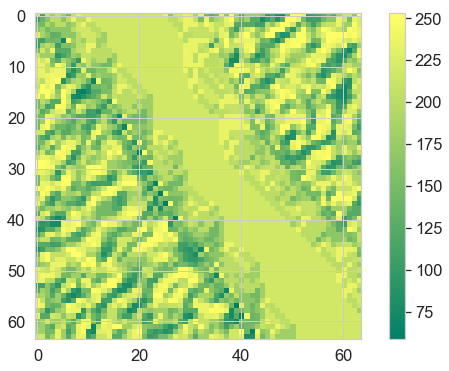

In [96]:
fig, ax = plt.subplots(figsize = (10,6))
hs_array = hillshade(dem_img, 315,45)
plot = ax.imshow(hs_array, cmap='summer');
fig.colorbar(plot);


In [91]:
hs_array

array([[222.51734607, 111.72355184, 208.8540764 , ..., 217.6561146 ,
        166.3540764 , 253.16381636],
       [109.18401273, 138.28025114, 165.94269643, ..., 149.06050229,
        236.3280573 , 225.35258039],
       [149.14506257, 147.49435688, 190.33190818, ..., 179.62821362,
        248.54036969, 224.83877359],
       ...,
       [179.62821362, 179.62821362, 146.1719427 , ..., 217.6561146 ,
        217.6561146 , 217.6561146 ],
       [179.62821362, 179.62821362, 146.1719427 , ..., 217.6561146 ,
        217.6561146 , 217.6561146 ],
       [217.6561146 , 217.6561146 , 146.1719427 , ..., 217.6561146 ,
        217.6561146 , 217.6561146 ]])

In [99]:
def aspect(array):

    # Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html

    x, y = np.gradient(array)
    print(x)
    print()
    print(y)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    print()
    print(slope)
    aspect = np.arctan2(-x, y)
    return aspect

In [100]:
as_array = aspect(dem_img)

[[ 8.  -4.   1.  ...  0.  -1.   1. ]
 [ 4.   1.  -1.5 ... -0.5  0.   0.5]
 [ 1.5  4.5  2.  ... -0.5  1.   0. ]
 ...
 [-0.5  0.   0.  ...  0.   0.   0. ]
 [-0.5 -0.5  0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]]

[[ 4.   1.5 -0.5 ...  0.   0.5  1. ]
 [-8.  -2.   1.5 ... -0.5  1.   3. ]
 [-2.  -4.  -1.  ...  0.   1.5  2. ]
 ...
 [ 0.  -0.5 -1.  ...  0.   0.   0. ]
 [ 0.   0.  -1.  ...  0.   0.   0. ]
 [ 0.   0.  -1.  ...  0.   0.   0. ]]

[[0.11134101 0.22994211 0.72972766 ... 1.57079633 0.72972766 0.61547971]
 [0.11134101 0.42053434 0.44051066 ... 0.95531662 0.78539816 0.31766319]
 [0.38050638 0.16458848 0.42053434 ... 1.10714872 0.50644464 0.46364761]
 ...
 [1.10714872 1.10714872 0.78539816 ... 1.57079633 1.57079633 1.57079633]
 [1.10714872 1.10714872 0.78539816 ... 1.57079633 1.57079633 1.57079633]
 [1.57079633 1.57079633 0.78539816 ... 1.57079633 1.57079633 1.57079633]]


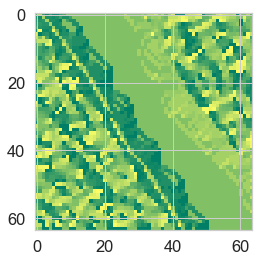

In [88]:
plt.imshow(as_array, cmap='summer')

In [90]:
as_array

array([[-1.10714872,  1.21202566, -2.03444394, ..., -0.        ,
         1.10714872, -0.78539816],
       [-2.67794504, -2.67794504,  0.78539816, ...,  2.35619449,
        -0.        , -0.16514868],
       [-2.49809154, -2.29743867, -2.03444394, ...,  1.57079633,
        -0.5880026 , -0.        ],
       ...,
       [ 1.57079633, -3.14159265, -3.14159265, ..., -0.        ,
        -0.        , -0.        ],
       [ 1.57079633,  1.57079633, -3.14159265, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -3.14159265, ..., -0.        ,
        -0.        , -0.        ]])

In [81]:
vmin = dem_img.min
vmax = dem_img.max

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'builtin_function_or_method'

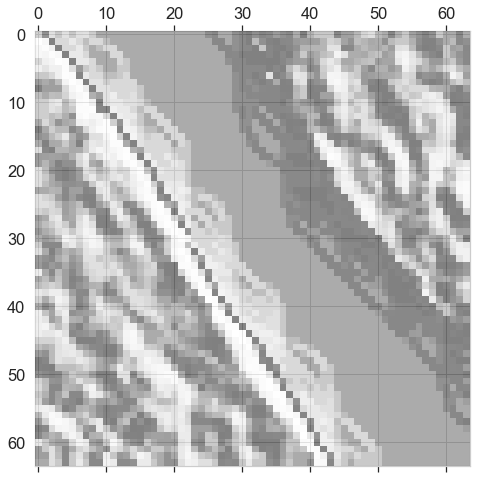

In [82]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.matshow(hillshade(dem_img, 30, 30), cmap='Greys', alpha=.5, zorder=10)
cax = ax.contourf(dem_img, np.arange(vmin, vmax, 10), 
                  cmap=topocmap, vmin=vmin, vmax=vmax, origin='image')
fig.colorbar(cax, ax=ax)
fig.savefig('images/8/2.png')


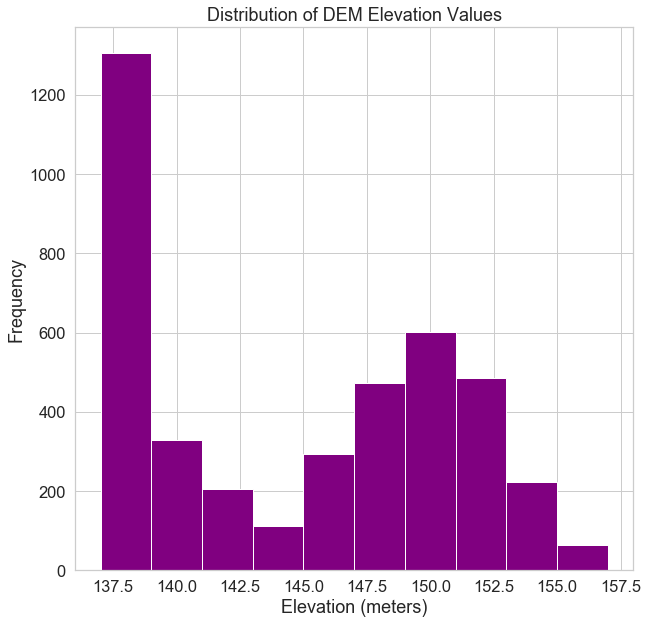

In [41]:
#plot a histogram of the raster elevations
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(dem_img.ravel(), color = 'purple')
ax.set(xlabel = "Elevation (meters)",
      ylabel = "Frequency",
      title = "Distribution of DEM Elevation Values");

RasterioIOError: Dataset is closed: /Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/SRTM_DEMs/test3857.tif

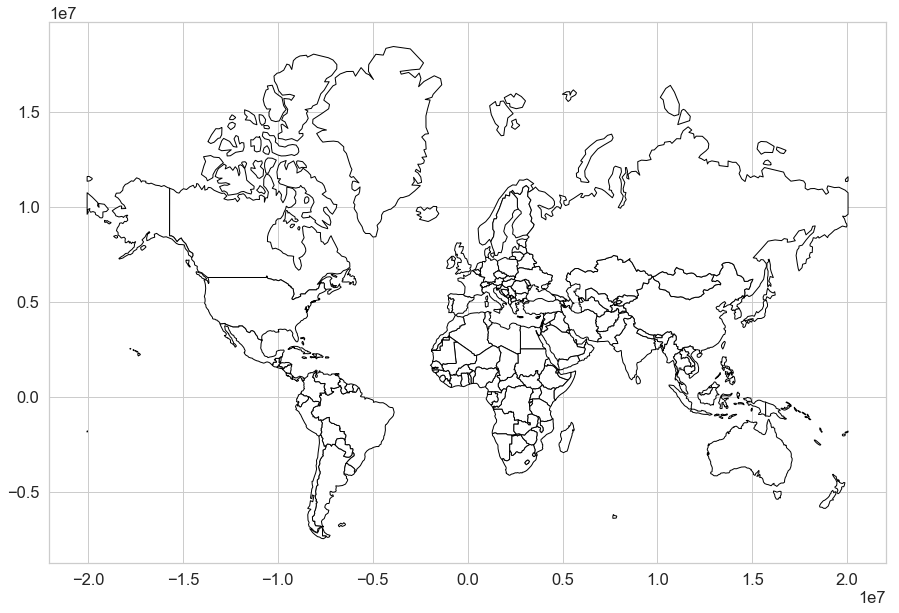

In [42]:
#plot the data
fig,ax = plt.subplots(figsize=(15,15))
world.plot(color = 'white',
           edgecolor = 'black',
           ax = ax)
show(dem_raster, ax=ax)

#loop through each attribute type and plot it using the colors assigned to the dictionary
for ctype, data in gdf.groupby("trend"):
    color = trendPalette[ctype]
    data.plot(color = color,
              ax = ax,
              label = ctype)

ax.legend(title = "Trend Type",
          loc = "lower left");
ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);

In [144]:
dem_raster.close()

In [142]:
dem_raster = rasterio.open(output)

In [143]:
dem_raster.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 65,
 'height': 62,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(0.0002777777777777778, 0.0, 104.77375,
        0.0, -0.0002777777777777778, 17.425694444444442)}

In [108]:
buffer.bounds.loc[0].minx

11663390.203791585

In [112]:
dem_raster.bounds

BoundingBox(left=104.77375, bottom=17.40847222222222, right=104.79180555555556, top=17.425694444444442)

In [113]:
pic = dem_raster.read(1)
bounds = (dem_raster.bounds.left,
          dem_raster.bounds.right,
          dem_raster.bounds.bottom,
          dem_raster.bounds.top)

(104.77375, 104.79180555555556)

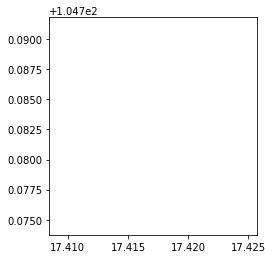

In [138]:
fig, ax = plt.subplots()
world.plot(ax = ax)
buffer.plot(color='r', ax = ax)
ax.imshow(pic, extent = bounds, alpha = 0.5)
ax.set_xlim(bounds[2:4])
ax.set_ylim(bounds[0:2])

In [131]:
bounds[0:2]

(104.77375, 104.79180555555556)

In [85]:
gdf.crs, world.crs, dem_raster.crs

({'init': 'epsg:3857'}, {'init': 'epsg:3857'}, CRS.from_dict(init='epsg:4326'))

In [86]:
bufferDecimal.bounds.loc[0]

minx    104.774017
miny     17.408429
maxx    104.791983
maxy     17.425571
Name: 0, dtype: float64

In [87]:
buffer.bounds.loc[0]

minx    1.166339e+07
miny    1.968421e+06
maxx    1.166539e+07
maxy    1.970421e+06
Name: 0, dtype: float64

In [91]:
src_crs = dem_raster.crs
src_shape = src_height, src_width = dem_raster.shape
src_transform = from_bounds(west, south, east, north, src_width, src_height)
source = dem_raster.read(1)

(62, 65)

In [105]:
dem_raster.close()